# Insurance: 360-degree customer view
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/atoti/blob/main/03-use-cases/01-finance/insurance/customer360/03-main-csv.ipynb)._]

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.8.4-blue">

An insurance company can have multiple contractual relationship with a customer, considering that it has multiple solutions that caters to different risk needs of individuals and corporates.  

Having a customer-centric view of the relationships one has with the insurance company has many advantages, e.g.:
- knowing the customers and their behavior better
- Ability to deliver more personalized experience 
- optimized marketing effort to capitalize opportunities and retaining customers

Legacy systems pose as a challenge for insurance companies to achieve a single customer view.  
With [Atoti](https://www.atoti.io/), we have created a simplified use case of how we can integrate data from different systems into a consolidated view for multidimensional data analytics for insurance industry.  

Mock data schema is being used for demonstrative purpose only.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=customer360" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
from datetime import datetime

import atoti as tt
import pandas as pd

## Setting up multidimensional analysis 

In [2]:
session = tt.Session(
    user_content_storage="./content", port=19091, java_options=["-Xms1G", "-Xmx10G"]
)

### Consolidating policies information

Insurance company A has three different systems storing the below policies:
- Life Insurance
- Property
- Vehicles

We will simplify consolidate the key features of the policy details for these 3 types of policies into a single table in Atoti.  
Atoti is able to read data from different sources such as [CSV, Parquet, Pandas and Spark dataframes](https://www.atoti.io/features/) etc.  
Refer to [02-main-vertica.ipynb](02-main-vertica.ipynb) on how to create a cube from [Vertica database](https://www.vertica.com/).

In this notebook, we will use CSV files or Pandas dataframe as our data source.
These data will be held in-memory.

In [3]:
policy_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/Policy_property.csv",
    table_name="policy",
    keys=["CUST_ID", "POLICY"],
    default_values={"NUM_SUBPOLICY": 0.0},
)

In [4]:
len(policy_tbl)

136665

#### Incremental dataloading from different type of data source

Atoti supports incremental data loading. As an example, we will combine the remaining policies into a single Pandas dataframe and load it into the existing `policy` table.

In [5]:
other_policies = pd.read_csv(
    "https://data.atoti.io/notebooks/customer360/Policy_life.csv"
)

vehicle_policies = pd.read_csv(
    "https://data.atoti.io/notebooks/customer360/Policy_vehicle.csv"
)

other_policies = pd.concat([other_policies, vehicle_policies])
print(len(other_policies))
other_policies.head()

19994


CUST_ID   POLICY POLICY_STATUS     POLICY_TYPE  QUOTE_DATE COVER_START  \
0  C00000014  L001760          Live  Life insurance  1998-10-29  1998-10-31   
1  C00000016  L011916          Live  Life insurance  2004-05-17  2004-05-31   
2  C00000032  L013466          Live  Life insurance  2004-12-20  2004-12-25   
3  C00000034  L061496          Live  Life insurance  2018-10-03  2018-10-05   
4  C00000044  L000030          Live  Life insurance  1993-10-30  1993-11-17   

  LAPSED_DATE CANCELLED_DATE MATURITY_DATE PAYMENT_METHOD PAYMENT_FREQUENCY  \
0         NaN            NaN    2032-02-01          NonDD            Annual   
1         NaN            NaN    2036-06-16       DD-Other            Annual   
2         NaN            NaN    2048-07-28         PureDD            Annual   
3         NaN            NaN    2062-10-01         PureDD            Annual   
4         NaN            NaN    2045-04-13         PureDD            Annual   

   SUM_INSURED OWNERSHIP PLAN_TYPE  BASIC_PREMIUM  NUM_SUBPOLICY IS_SUB  
0    1000000.0       NaN         B          903.0              0      N  
1    1000000.0       NaN         B          903.0              0      N  
2    1000000.0       NaN         B          903.0              0      N  
3    1000000.0       NaN         B          903.0              0      N  
4    1000000.0       NaN         B          903.0              0      N

We need to ensure that the numerical columns and date columns are of the correct data type before loading them into the Atoti table.  
The following cell is how we can see the data type of the columns.

In [6]:
policy_tbl

We can cast the columns to the respective data type of the Atoti table.

In [7]:
other_policies["QUOTE_DATE"] = pd.to_datetime(other_policies["QUOTE_DATE"])
other_policies["COVER_START"] = pd.to_datetime(other_policies["COVER_START"])
other_policies["LAPSED_DATE"] = pd.to_datetime(other_policies["LAPSED_DATE"])
other_policies["CANCELLED_DATE"] = pd.to_datetime(other_policies["CANCELLED_DATE"])
other_policies["MATURITY_DATE"] = pd.to_datetime(other_policies["MATURITY_DATE"])

other_policies.dtypes

CUST_ID                      object
POLICY                       object
POLICY_STATUS                object
POLICY_TYPE                  object
QUOTE_DATE           datetime64[ns]
COVER_START          datetime64[ns]
LAPSED_DATE          datetime64[ns]
CANCELLED_DATE       datetime64[ns]
MATURITY_DATE        datetime64[ns]
PAYMENT_METHOD               object
PAYMENT_FREQUENCY            object
SUM_INSURED                 float64
OWNERSHIP                    object
PLAN_TYPE                    object
BASIC_PREMIUM               float64
NUM_SUBPOLICY                 int64
IS_SUB                       object
dtype: object

In the initial loading, we used the `read_*` function to initial the table. For incremental loading, we will use the `load_*` function from the table variable - `policy_tbl`.

In [8]:
policy_tbl.load_pandas(other_policies)

In [9]:
len(policy_tbl)

156659

In [10]:
policy_tbl.head()

POLICY_STATUS POLICY_TYPE QUOTE_DATE COVER_START  \
CUST_ID   POLICY                                                     
C00095917 P094740          Live    Property 2006-12-23  2006-12-30   
C00095925 P023470        Lapsed    Property 2009-12-22  2009-12-25   
C00000023 P066917          Live    Property 1994-01-15  1994-01-30   
C00095957 P108933        Lapsed    Property 2011-02-16  2011-02-28   
C00095958 P187967          Live    Property 2011-09-20  2011-10-01   

                  LAPSED_DATE CANCELLED_DATE MATURITY_DATE PAYMENT_METHOD  \
CUST_ID   POLICY                                                            
C00095917 P094740  1970-01-01     1970-01-01    2036-12-30          NonDD   
C00095925 P023470  2018-09-04     1970-01-01    2039-12-25         PureDD   
C00000023 P066917  1970-01-01     1970-01-01    2024-01-30         PureDD   
C00095957 P108933  2019-10-17     1970-01-01    2041-02-28         PureDD   
C00095958 P187967  1970-01-01     1970-01-01    2041-10-01         PureDD   

                  PAYMENT_FREQUENCY  SUM_INSURED OWNERSHIP PLAN_TYPE  \
CUST_ID   POLICY                                                       
C00095917 P094740            Annual     140000.0  Landlord         A   
C00095925 P023470           3 Years      65000.0    Tenant         B   
C00000023 P066917           3 Years     230000.0  Landlord         B   
C00095957 P108933           3 Years     110000.0  Landlord         A   
C00095958 P187967            Annual     135000.0    Tenant         A   

                   BASIC_PREMIUM  NUM_SUBPOLICY IS_SUB  
CUST_ID   POLICY                                        
C00095917 P094740          58.86            1.0      N  
C00095925 P023470         293.32            0.0      N  
C00000023 P066917         293.32            2.0      N  
C00095957 P108933         150.09            0.0      N  
C00095958 P187967          58.86            1.0      N

#### Additional coverage 

Some property policies may have added optional coverage by topping up the premiums. The add-ons has its own insured sum.  
In the case of "Family personal accident" add-on for instance, it covers the spouse and up to 3 children.

We will add these subpolicies into the main policy table with the `IS_SUB` indicator set to `Y`, so that the sub-policy holders will be able to see their policies.

In [11]:
policy_tbl.load_csv("s3://data.atoti.io/notebooks/customer360/Sub_Policy.csv")

We will also create a table for the additional coverage, so that we can see the sub-policies related to the main policies.

In [12]:
addons_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/additional_coverage.csv",
    table_name="additional_coverage",
    keys=["POLICY", "SUB_POLICY"],
)

addons_tbl.head()

ADD_SUM_INSURED         ADD_COVERAGE_TYPE  PREMIUM  \
POLICY  SUB_POLICY                                                        
P000001 FPA00075885          50000.0  Family personal accident    62.50   
P000016 FPA00077189          50000.0  Family personal accident    62.50   
P000182 PL00042017          500000.0        Personal liability    76.50   
P000229 PL00028137          500000.0        Personal liability    76.50   
P000257 FPA00037223          50000.0  Family personal accident   159.38   

                    RELATION    INSURED  
POLICY  SUB_POLICY                       
P000001 FPA00075885  Insured  C00048248  
P000016 FPA00077189  Insured  C00033487  
P000182 PL00042017   Insured  C00078457  
P000229 PL00028137   Insured  C00007110  
P000257 FPA00037223  Insured  C00036252

In [13]:
policy_tbl.join(addons_tbl)

#### Adding policy coverage information

Just to demonstrate how we can integrate details of policy, we will include the coverage of the property policies into the cube.

In [14]:
coverage_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/coverage.csv",
    table_name="coverage",
    keys=["POLICY", "COVERAGE_TYPE"],
)

coverage_tbl.head()

SUM_INSURED
POLICY  COVERAGE_TYPE                  
P000001 Contents                  35000
        Personal Liability       500000
P000015 Contents                  25000
P000021 Renovation               175000
P000026 Personal Liability       500000

We can now join the coverage table to the policy table.

In [15]:
policy_tbl.join(coverage_tbl)

### Creating a cube with policy views

Now that we have joined all the tables pertaining to the policies, we can now create a cube and look at the schema.

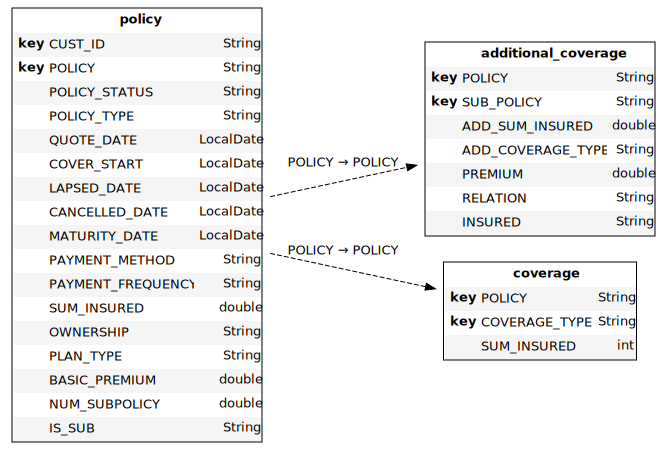

In [16]:
cube = session.create_cube(policy_tbl, "Insurance")
cube.schema

We will be able start creating visualizations based on the data schema that we have.  
The below pivot table allows us to have a quick view on the status of the policies that each customer has.

In [17]:
session.visualize("Policy overview by customers")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Enriching cube with customer table

Finally, we can enrich the cube with client information:

In [18]:
customer_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/customer.csv",
    table_name="customer",
    keys=["CUST_ID", "AGE"],
)

In [19]:
customer_tbl.head()

DOB EMPLOYMENT_STATUS MARITAL_STATUS  GENDER STATE  \
CUST_ID   AGE                                                             
C00106559 54  1967-09-22     Self-employed          Other    Male   QLD   
C00106661 55  1966-09-24        Freelancer        Married  Female   NSW   
C00106668 61  1960-06-30           Retired          Other    Male   VIC   
C00106675 63  1957-12-08          Employed          Other    Male   QLD   
C00106715 33  1988-08-07          Employed          Other    Male   VIC   

                    CITY           INCOME                            EDUCATION  
CUST_ID   AGE                                                                   
C00106559 54      Cairns        1 - 9,999  Certificate in Vocational Education  
C00106661 55      Sydney  50,000 - 74,999                        Not specified  
C00106668 61   Melbourne  25,000 - 49,999                    Technical Diploma  
C00106675 63    Brisbane  100,000 or more  Certificate in Vocational Education  
C00106715 33   Melbourne  50,000 - 74,999                        Not specified

In [20]:
policy_tbl.join(customer_tbl)

### Adding analytic tables

We can enrich the cube further with information such as the longitude and latitude for the location where the clients are based in. 

In [21]:
location_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/location.csv",
    table_name="location",
    keys=["STATE", "CITY"],
)

location_tbl.head(2)

STATE_NAME    COUNTRY   LATITUDE  LONGITUDE
CITY      STATE                                                  
Newcastle NSW    New South Wales  Australia -32.916668   151.7500
Sydney    NSW    New South Wales  Australia -33.865143   151.2099

Or we can use Pandas dataframe to create a table that will give us "Age groups".

In [22]:
age_groups_tbl = session.read_pandas(
    pd.DataFrame(
        data=[("0-17Y", i) for i in range(18)]
        + [("18-64Y", i) for i in range(18, 65)]
        + [("65Y+", i) for i in range(65, 100)],
        columns=["AGE GROUP", "AGE"],
    ),
    table_name="Age_Groups",
    keys=["AGE"],
)

age_groups_tbl.head(2)

AGE GROUP
AGE          
19     18-64Y
39     18-64Y

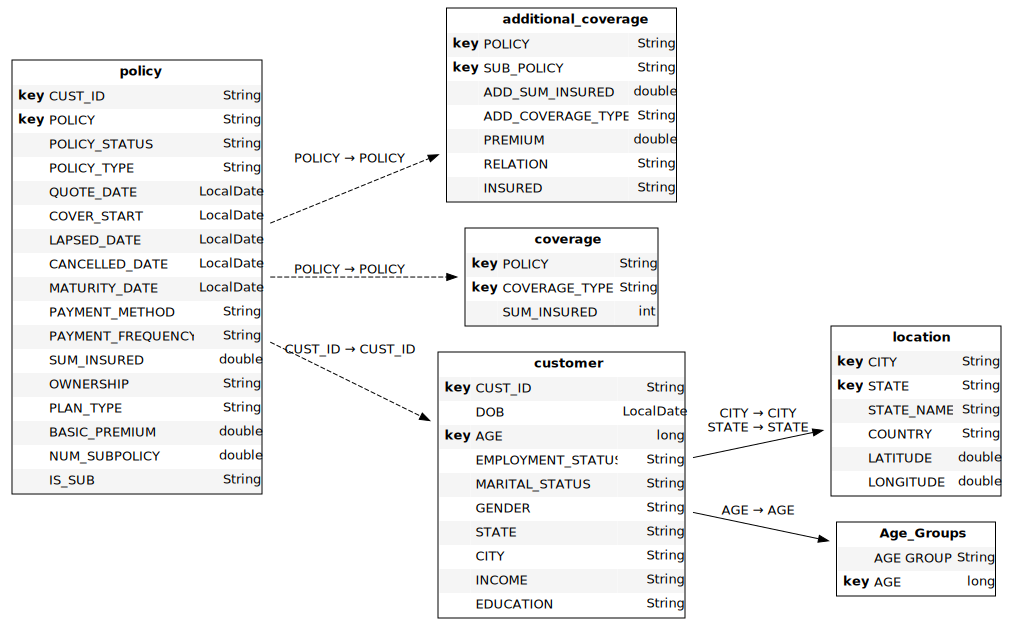

In [23]:
customer_tbl.join(age_groups_tbl)
customer_tbl.join(location_tbl)

cube.schema

### Adding policy claims

In our simplified use case, we will only look at the claims from vehicle policies.

In [24]:
claim_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/claims.csv",
    table_name="claim",
    keys=["POLICY", "CLAIM_DATE"],
)

policy_tbl.join(claim_tbl)

In [25]:
claim_tbl.head()

CLAIM_AMOUNT  CLAIM_REASON
POLICY  CLAIM_DATE                            
V000122 2020-07-13       1682.42  Scratch/Dent
V000283 2011-12-21       4933.14     Collision
V000555 2013-05-06        368.87     Collision
V000608 2013-03-27        233.20     Collision
V000626 2012-07-16        553.20         Other

### Generating timeline for policy (with exclusion of Payment module)

Keeping the notebook simple, we will exclude the payment module. However, we should still be able to perform some simple analytics to look at the increase in premiums due to newly added policies; or the decrease due to the cancellation, lapsed or maturity of existing policies.  

To do this, we create a timeline for the policies, covering the cover start date, lapsed date, cancelled date and maturity date. We will not include renewal in this use case.  
Feel free to expand on the use case.

In [26]:
timeline_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/timeline.csv",
    table_name="timeline",
    keys=["POLICY"],
)

In [27]:
policy_tbl.join(timeline_tbl)

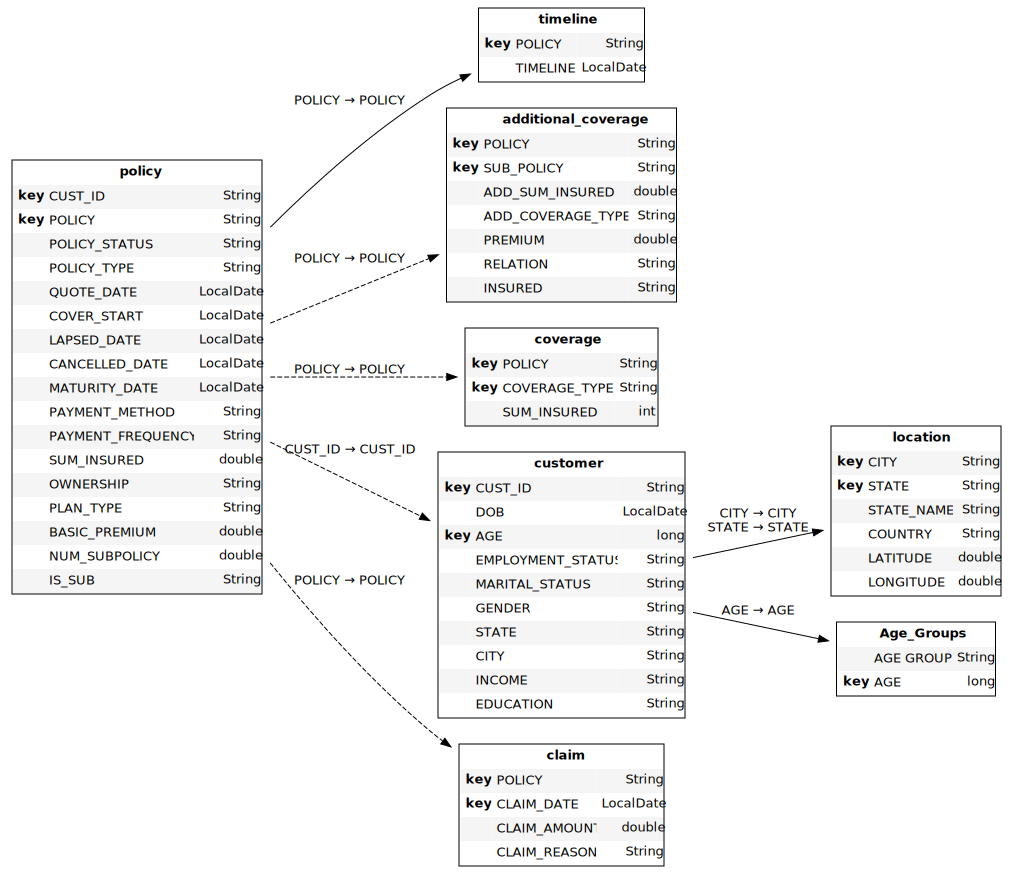

In [28]:
cube.schema

### Enabling aggregation sharing without caching

We can configure the [aggregation cache](https://docs.atoti.io/latest/lib/atoti.aggregates_cache.html#atoti.aggregates_cache.AggregatesCache.capacity) of the cube to share computation from queries if they are executed at the same time, with or without caching.

In [29]:
cube.aggregates_cache.capacity = 0

## Visualizing data in "as-is" state  

Based on what is loaded from the various data sources, we are able to start creating visuals without having to worry about the relationships between the table.  
Users will only need to know what are the hierarchies and measures that they want to explore.

In [30]:
session.visualize("Policy status by policy type")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

The above charts give the policy status across the entire timeline of our dataset. It may seem that vehicle policies have higher cancellation rate and property policies are more likely to lapse.  

Let's add timeline to our visualization to put things into perspective. But before that, we need to create some measures to perform some aggregation.

## Manipulating hierarchies and measures

The cube has the below attributes that we will use to create our measures.

In [31]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Create date hierarchy on the timeline

We have the timeline for the various milestones of the policy. By creating a [date hierarchy](https://docs.atoti.io/latest/lib/atoti.experimental.html#atoti.experimental.create_date_hierarchy), we can view our measures on yearly, quarterly or monthly basis.

In [32]:
cube.create_date_hierarchy(
    "Time",
    column=timeline_tbl["TIMELINE"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM"},
)

### Creating measures  

#### Resiliation rate

We compute the resiliance rate by taking the number of lapsed and cancelled policies against the total number of policies.

In [33]:
m["Number of lapsed policies"] = tt.agg.sum(
    tt.where(l["POLICY_STATUS"] == "Lapsed", m["contributors.COUNT"]),
    scope=tt.OriginScope(
        l["POLICY_STATUS"], l["POLICY"], l["CUST_ID"], l["POLICY_TYPE"]
    ),
)

m["Number of cancelled policies"] = tt.agg.sum(
    tt.where(l["POLICY_STATUS"] == "Cancelled", m["contributors.COUNT"]),
    scope=tt.OriginScope(
        l["POLICY_STATUS"], l["POLICY"], l["CUST_ID"], l["POLICY_TYPE"]
    ),
)

m["Number of live policies"] = tt.agg.sum(
    tt.where(l["POLICY_STATUS"] == "Live", m["contributors.COUNT"]),
    scope=tt.OriginScope(
        l["POLICY_STATUS"], l["POLICY"], l["CUST_ID"], l["POLICY_TYPE"]
    ),
)

In [34]:
m["Resiliation rate"] = (
    m["Number of lapsed policies"] + m["Number of cancelled policies"]
) / m["contributors.COUNT"]
m["Resiliation rate"].formatter = "DOUBLE[#.00%]"

In [35]:
session.visualize("Resiliance rate of each policy type")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

Putting the resiliation rate against the timeline hierarchy, we can see that property type policies are more likely to lapse than the other two policies based on the past 5 years performance. There is also an gradual increase in resiliation over the years.

In [36]:
session.visualize("Resiliation rate of each policy type for the past 5 years")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

#### Policy durations

We can compute measures for moving dates, such as the policy duration, months from inception etc from the current date.  
The current date is derived using the [Python function datetime](https://docs.python.org/3/library/datetime.html).  

We can apply conditions to compute the durations, putting the policy status into consideration:

In [37]:
m["Policy duration"] = tt.agg.mean(
    tt.switch(
        l["POLICY_STATUS"],
        {
            "Lapsed": tt.date_diff(l["COVER_START"], l["LAPSED_DATE"], unit="years"),
            "Cancelled": tt.date_diff(
                l["COVER_START"], l["CANCELLED_DATE"], unit="years"
            ),
        },
        default=tt.date_diff(l["COVER_START"], l["MATURITY_DATE"], unit="years"),
    ),
    scope=tt.OriginScope(
        l["POLICY_STATUS"],
        l["COVER_START"],
        l["LAPSED_DATE"],
        l["CANCELLED_DATE"],
        l["MATURITY_DATE"],
        l["POLICY"],
        l["CUST_ID"],
    ),
)

m["Months from inception"] = tt.agg.mean(
    tt.switch(
        l["POLICY_STATUS"],
        {
            "Lapsed": tt.date_diff(l["COVER_START"], l["LAPSED_DATE"], unit="months"),
            "Cancelled": tt.date_diff(
                l["COVER_START"], l["CANCELLED_DATE"], unit="months"
            ),
        },
        default=tt.date_diff(l["COVER_START"], datetime.today(), unit="months"),
    ),
    scope=tt.OriginScope(
        l["POLICY_STATUS"],
        l["COVER_START"],
        l["LAPSED_DATE"],
        l["CANCELLED_DATE"],
        l["MATURITY_DATE"],
        l["POLICY"],
        l["CUST_ID"],
    ),
)

m["Policy duration"].formatter = "DOUBLE[#]"
m["Months from inception"].formatter = "DOUBLE[#]"

#### No Claims Discount (NCD)

Based on the Policy plan type and the number of years without claims, discounts are given to the policy.  
We will load the discounts configuration for vehicle policies into the cube for computation of the final premiums.

In [38]:
ncd_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/ncd.csv",
    table_name="NCD",
    keys=["POLICY_TYPE", "PLAN", "NCD_YEARS"],
)

In [39]:
ncd_tbl.head()

DISCOUNT
POLICY_TYPE PLAN              NCD_YEARS          
Vehicle     Personal Basic    1               0.1
            Corporate Premium 1               0.2
            Personal Basic    2               0.2
            Corporate Premium 3               0.3
            Special Premium   2               0.3

We can explicitly define the mapping between the tables.

In [40]:
policy_tbl.join(
    ncd_tbl,
    (policy_tbl["PLAN_TYPE"] == ncd_tbl["PLAN"])
    & (policy_tbl["POLICY_TYPE"] == ncd_tbl["POLICY_TYPE"]),
)

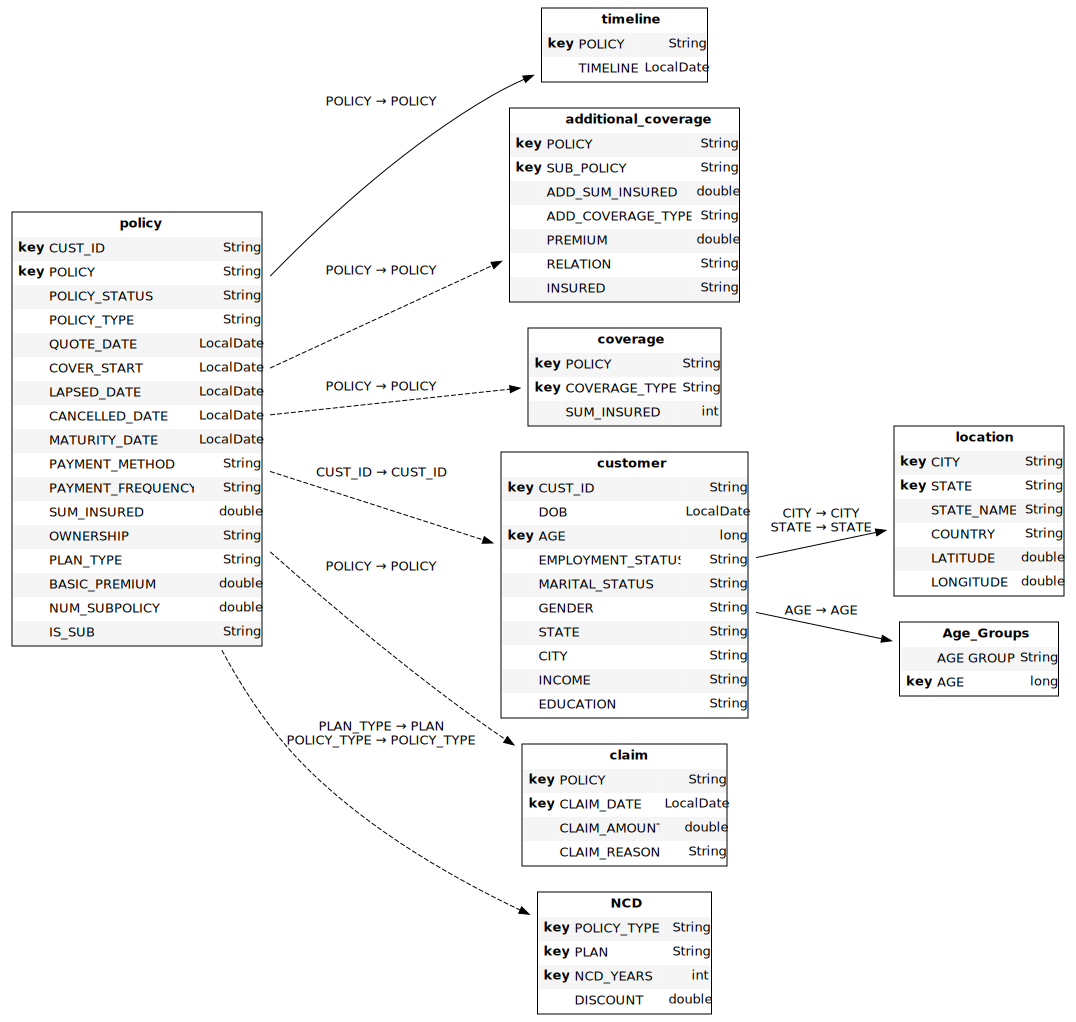

In [41]:
cube.schema

We will first compute the number of months since the last claim was made. Then we can derive the number of years without claims.  
Note that we are using the python function `datetime` to get the NCD with reference to the current date. Hence, the NCD is computed based on a moving date.

In [42]:
default_date = datetime.strptime("1970/01/01", "%Y/%d/%m").date()

In [43]:
m["Months since claim"] = tt.where(
    l["CLAIM_DATE"] == default_date,
    tt.date_diff(l["COVER_START"], datetime.today(), unit="months"),
    tt.date_diff(l["CLAIM_DATE"], datetime.today(), unit="months"),
)
m["Last claim date"] = tt.where(
    l["CLAIM_DATE"] == default_date,
    tt.agg.min_member(m["Months since claim"], l["COVER_START"]),
    tt.agg.min_member(m["Months since claim"], l["CLAIM_DATE"]),
)

m["Months since last claims"] = tt.date_diff(
    m["Last claim date"],
    datetime.today(),
    unit="months",
)

m["Policy NCD"] = tt.agg.min(
    tt.math.floor(m["Months since last claims"] / 12),
    scope=tt.OriginScope(l["POLICY"], l["CLAIM_DATE"], l["COVER_START"]),
)

We will take the most recent claim to compute the NCD period for the policy.

In [44]:
session.visualize("Period since last claims for vehicles")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

Note that there is a max number of years for the NCD. Beyond this number of years, the amount of discount given is the same.  
We will get the max NCD period for each of the policy plan.

In [45]:
m["NCD Years"] = tt.where(
    (~l["NCD_YEARS"].isnull()) & (~l["PLAN_TYPE"].isnull()),
    tt.agg.single_value(ncd_tbl["NCD_YEARS"]),
)

m["Max NCD Year"] = tt.agg.mean(
    tt.agg.max(m["NCD Years"], scope=tt.SiblingsScope(hierarchy=h["NCD_YEARS"])),
    scope=tt.OriginScope(l["PLAN_TYPE"], l["POLICY"]),
)

As the NCD discounts are in the referenced table, we will need to create a measure for it manually.

In [46]:
m["NCD Disounts"] = tt.agg.mean(ncd_tbl["DISCOUNT"])

We apply the discount depending on the number of NCD years the policy has. Otherwise, no discount is given.

In [47]:
m["Applied discount"] = tt.agg.mean(
    tt.where(
        (m["Policy NCD"] >= m["Max NCD Year"]) & (m["Max NCD Year"] == l["NCD_YEARS"])
        | (l["NCD_YEARS"] == m["Policy NCD"]),
        m["NCD Disounts"],
        0,
    ),
    scope=tt.OriginScope(l["NCD_YEARS"]),
)

m["Applied discount"].formatter = "DOUBLE[#.000%]"

We will aggregate the premiums after applying the discount. For all other insurances without NCD, we will take the value of the basic premium.

In [48]:
m["Discounted premium"] = tt.agg.sum(
    tt.agg.sum(
        tt.where(
            l["NCD_YEARS"] == 0,
            m["BASIC_PREMIUM.SUM"],
            tt.where(
                (m["Applied discount"] != 0),
                (1 - m["Applied discount"]) * m["BASIC_PREMIUM.SUM"],
            ),
        ),
        scope=tt.OriginScope(l["NCD_YEARS"]),
    ),
    scope=tt.OriginScope(l["POLICY"]),
)

From the below table, we see that with increasing NCD, the amount of discount given is higher.  

In [49]:
session.visualize("Computation of premiums after NCD")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

#### Claims

In this use case, we only have the claim information for vehicle type policies.

In [50]:
m["Claim Amount"] = tt.agg.sum(
    tt.agg.single_value(claim_tbl["CLAIM_AMOUNT"]),
    scope=tt.OriginScope(l["POLICY"], l["CLAIM_DATE"]),
)

In [51]:
session.visualize("Claim amount in Year 2020")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

#### Additional coverage measures

Before we compute the total premiums and sum assured for a customer, let's create the measure for the additional coverage.

In [52]:
m["Add. coverage premium"] = tt.agg.sum(addons_tbl["PREMIUM"])
m["Add. sum insured"] = tt.agg.sum(addons_tbl["ADD_SUM_INSURED"])

In [53]:
session.visualize("Additional coverage for customer C00035686")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

#### Computing the premium

We compute the total premium at the point of inception. This will give us some insight on the incoming premium based on the cover start date.  

Since payment frequency can be monthly, annually or 3 Yearly, we breakdown the premium to monthly denominator.

In [54]:
m["Total premium"] = m["BASIC_PREMIUM.SUM"] + m["Add. coverage premium"]

In [55]:
m["Initial total monthly premium"] = tt.agg.sum(
    tt.where(
        l["PAYMENT_FREQUENCY"] == "Annual",
        m["Total premium"] / 12,
        tt.where(
            l["PAYMENT_FREQUENCY"] == "3 Years",
            m["Total premium"] / 36,
            tt.where(l["PAYMENT_FREQUENCY"] == "Month", m["Total premium"]),
        ),
    ),
    scope=tt.OriginScope(l["PAYMENT_FREQUENCY"]),
)

Let's take into consideration the NCD discounts as of the current status of the premium to see how much has changed:

In [56]:
m["Total discounted premium"] = m["Discounted premium"] + m["Add. coverage premium"]

In [57]:
m["Current total monthly premium"] = tt.agg.sum(
    tt.where(
        l["PAYMENT_FREQUENCY"] == "Annual",
        m["Total discounted premium"] / 12,
        tt.where(
            l["PAYMENT_FREQUENCY"] == "3 Years",
            m["Total discounted premium"] / 36,
            tt.where(l["PAYMENT_FREQUENCY"] == "Month", m["Total discounted premium"]),
        ),
    ),
    scope=tt.OriginScope(l["PAYMENT_FREQUENCY"]),
)

In [58]:
m["Change in premium"] = (
    m["Initial total monthly premium"] - m["Current total monthly premium"]
)

In [59]:
session.visualize("Change in premium from inception till now")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Exploring customer demographics  

We can look at the demographics of the customer by their age groups, income or location.

In [60]:
m["Customer count"] = tt.agg.count_distinct(customer_tbl["CUST_ID"])

In [61]:
session.visualize("Policy status by age group")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

In [62]:
session.visualize("Sum insured across Australia")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Toggling between measure and hierarchy

There are instances when a data column is useful as a hierarchy or as a measure. 

#### Hierarchy to measure - Age exploration

Let's look at `AGE` from the `Age_Groups` and `customer` tables for instance.  

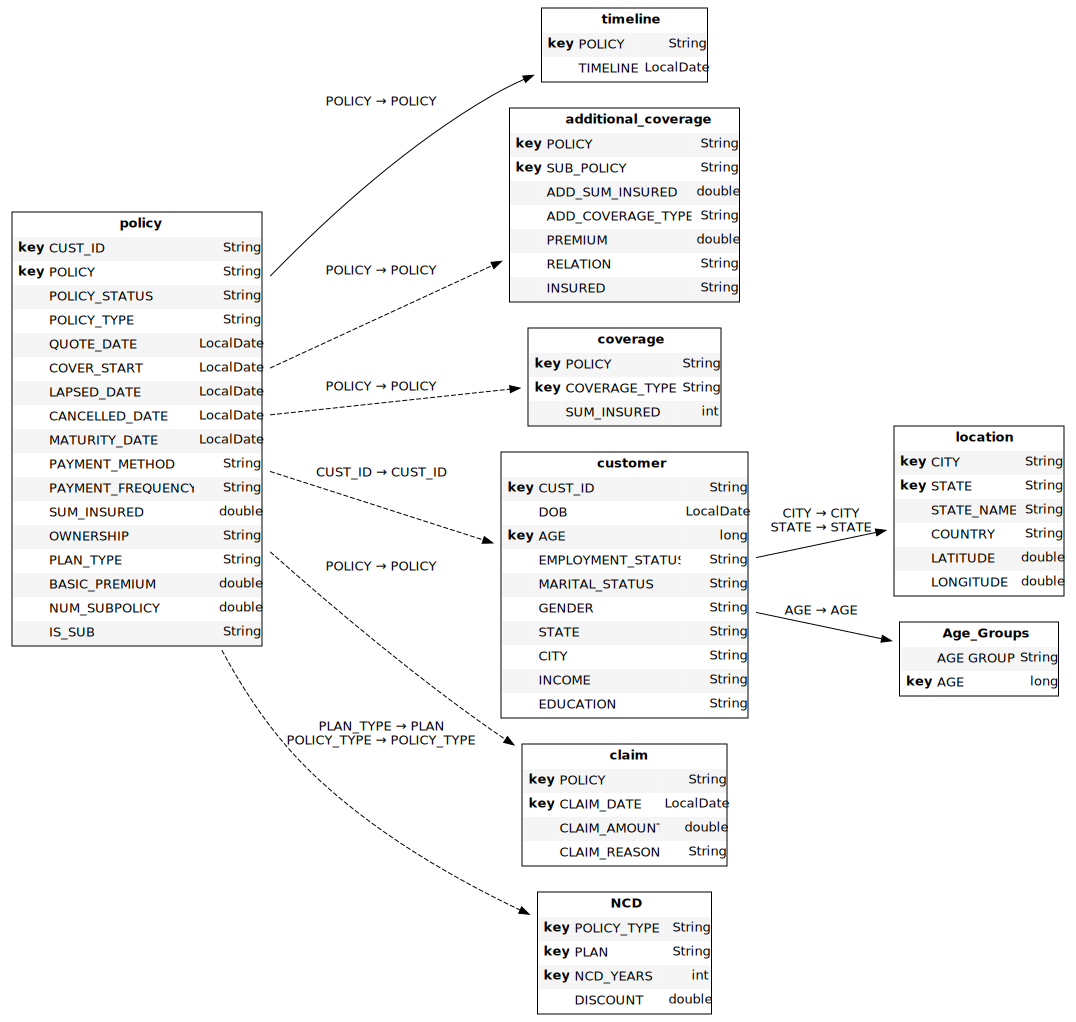

In [63]:
cube.schema


Atoti automatically creates as a hierarchy since the `AGE` column is the key of a table.  
However, that doesn't stop us from using it as a measure. Simply create the measure by aggregating the column from the table.

In [64]:
m["age"] = tt.agg.mean(customer_tbl["AGE"])

We can see from the below chart, people from the 25-65 age range is more likely to cancel their policies and generally within the first 15 years from inception.

In [65]:
session.visualize("Duration of cancelled policy by age")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

It is also worthy to note that the age range has the most buying power and forms the majority of the policyholders.

In [66]:
session.visualize("No. of policies by age")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

## Dashboarding

In [67]:
session.link(path="/#/dashboard/03f")

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

Draw insights based on the customers' demographics or interactively select customers to see the details of their policies.

<img src="customer_360.gif" alt="Customer 360">

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=customer360" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>